In [22]:
import os
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline

from collections import Counter
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller

In [4]:
df = pd.read_csv('train.csv')
df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,9796,CA-2017-125920,21/05/2017,28/05/2017,Standard Class,SH-19975,Sally Hughsby,Corporate,United States,Chicago,Illinois,60610.0,Central,OFF-BI-10003429,Office Supplies,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.7980
9796,9797,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,OFF-AR-10001374,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.3680
9797,9798,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10004977,Technology,Phones,GE 30524EE4,235.1880
9798,9799,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10000912,Technology,Phones,Anker 24W Portable Micro USB Car Charger,26.3760


In [5]:
df.drop('Row ID',axis = 1, inplace = True)

In [6]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format= '%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format= '%d/%m/%Y')

In [7]:
df['ShippingTime'] = df['Ship Date'] - df['Order Date']
df['ShippingTime']

0      3 days
1      3 days
2      4 days
3      7 days
4      7 days
        ...  
9795   7 days
9796   5 days
9797   5 days
9798   5 days
9799   5 days
Name: ShippingTime, Length: 9800, dtype: timedelta64[ns]

In [9]:
df.sort_values(by=['Order Date'], inplace=True, ascending=True)
df.set_index("Order Date", inplace = True)

In [10]:
salesdata = pd.DataFrame(df['Sales'])
salesdata

,Sales
Order Date,
2015-01-03,16.448
2015-01-04,3.540
2015-01-04,272.736
2015-01-04,11.784
2015-01-05,19.536
...,...
2018-12-30,90.930
2018-12-30,20.720
2018-12-30,323.136


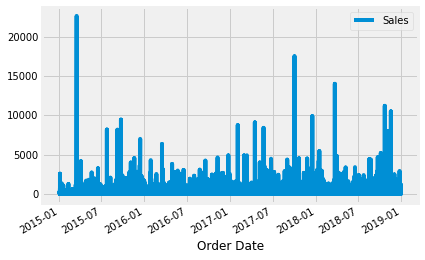

In [12]:
salesdata.plot()

In [14]:
salesdata =  pd.DataFrame(salesdata['Sales'].resample('D').mean())
salesdata = salesdata.interpolate(method='linear')

In [17]:
train, test, validate = np.split(salesdata['Sales'].sample(frac=1), [int(.6*len(salesdata['Sales'])),int(.8*len(salesdata['Sales']))])
print('Train Dataset' + ':' + ' ')
print(train)
print('---------------------------')
print('Test Dataset' + ':' + ' ')
print(test)
print('---------------------------')
print('Validate Dataset' + ':' + ' ')
print(validate)


Train Dataset: 
Order Date
2017-09-01    288.307600
2015-11-15    222.602750
2018-02-10    113.551500
2018-04-11     45.686571
2018-09-10    139.258111
                 ...    
2017-06-21    144.277000
2016-12-10    154.019000
2018-04-08    800.241250
2017-01-30    310.731600
2016-08-17     76.328000
Name: Sales, Length: 874, dtype: float64
---------------------------
Test Dataset: 
Order Date
2017-02-06    132.224000
2017-05-27    757.868286
2015-06-04     91.254400
2015-04-06    126.976154
2016-04-14     35.208000
                 ...    
2015-08-30     60.620000
2017-11-05    224.573621
2016-03-08    320.412000
2015-11-10    166.879667
2018-05-04    114.624500
Name: Sales, Length: 292, dtype: float64
---------------------------
Validate Dataset: 
Order Date
2015-12-13     48.858667
2016-09-22    162.136727
2017-11-04    194.440900
2017-12-07    286.968652
2018-02-11    248.303200
                 ...    
2018-10-25    182.264650
2016-10-15    402.444250
2018-01-14     69.733800
2017

In [21]:
mean1, mean2, mean3 = train.mean(), test.mean(), validate.mean()
var1, var2, var3 = train.var(), test.var(), validate.var()

print('Train Mean:' + str(mean1))
print('Test Mean:' + str(mean2))
print('Validate Mean:' + str(mean3))
print('---------------------------')
print('Train Variance:' + str(var1))
print('Test Variance:' + str(var2))
print('Validate Variance:' + str(var3))

Train Mean:224.98813294858496
Test Mean:210.7359926039323
Validate Mean:226.95106827326435
---------------------------
Train Variance:76235.14123933892
Test Variance:53209.36282142196
Validate Variance:78083.20229451553


In [ ]:
adf = adfuller(salesdata) 

print(adf)
print('\nADF = ', str(adf[0])) 
print('\np-value = ', str(adf[1]))
print('\nCritical Values: ')

for key, val in adf[4].items():
    print(key,':',val)
    

    if adf[0] < val:
        print('Null Hypothesis Rejected. Time Series is Stationary')
    else:
        print('Null Hypothesis Accepted. Time Series is not Stationary')